In [1]:
import geopy.distance
import numpy as np
import pandas as pd
from random import choices


# 1. Generating data

In [2]:
nestle_coord = (46.466634011, 6.835639010)
density_coord = pd.read_csv('STATPOP2021_WGS84.csv')
distance_cutoff = 20

In [3]:
density_coord_nestle = density_coord[density_coord.apply(
    lambda row: geopy.distance.distance(
        (row.latitude, row.longitude), nestle_coord).km < distance_cutoff,
    axis=1)
].reset_index(drop=True)
total_pop = density_coord_nestle.B21BTOT.sum()
density_coord_nestle['propability_density'] = (density_coord.B21BTOT / total_pop);

density_coord_nestle.to_csv('STATPOP2021_WGS84.csv')

Draw 50 employees location from the density function around Nestle's HQ

In [4]:
n_employees = 10
employee_indexes = choices(density_coord_nestle.index, density_coord_nestle.propability_density, k=n_employees)
employee_locations = density_coord_nestle.iloc[employee_indexes][['latitude', 'longitude']]

# We have to account for the possibility that more than one employees live at the same location
employee_locations_grouped = employee_locations.groupby([employee_locations.index, 'latitude', 'longitude'],
                                                        as_index=False).size()

In [5]:
coordinates_list = list(zip(employee_locations.latitude.tolist(), employee_locations.longitude.tolist()))
coordinates_string = [f'{str(x)},{str(y)}' for x, y in coordinates_list[1:5]]

In [6]:
destinations_fmt = '|'.join(coordinates_string).replace(' ', "%20").replace(',', '%2C')
destinations_fmt

'46.53543111798884%2C6.64738933762074|46.52638118733916%2C6.639701606841733|46.332623145048586%2C6.882815300107296|46.53243408285804%2C6.605720624284068'

# 2. Building the distance matrix

In [8]:
import os
from dotenv import load_dotenv
import requests
import json

load_dotenv()
key = os.getenv('GCP_KEY_0X')

In [ ]:
# origin = "Nestle, Vevey"
#
# # The destination parameter is in URL-format (only ASCII) and multiple entries are separated by colons |
# destinations_fmt = '|'.join(coordinates_string).replace(' ', "%20").replace(',', '%2C')
#
# url = f'https://maps.googleapis.com/maps/api/distancematrix/json' \
#       f'?origins={origin}' \
#       f'&destinations={destinations_fmt}' \
#       f'&units=metric' \
#       f'&key={key}'

url = 'https://routes.googleapis.com/distanceMatrix/v2:computeRouteMatrix'
headers = {
    'Content-Type': 'application/json',
    'X-Goog-Api-Key': key,
    'X-Goog-FieldMask': 'originIndex,destinationIndex,duration,distanceMeters,status,condition'
}
payload = str({
    'origins': [{'waypoint': {
        'location': {
            'latLng': {
                'latitude': latitude,
                'longitude': longitude
            }
        }
    }} for latitude, longitude in coordinates_list],
    'destinations': [{'waypoint': {
        'location': {
            'latLng': {
                'latitude': latitude,
                'longitude': longitude
            }
        }
    }} for latitude, longitude in coordinates_list],
    'travelMode': 'DRIVE',
    'routingPreference': 'TRAFFIC_AWARE'
})
response = requests.request('POST', url, headers=headers, data=payload)

In [122]:
distance_matrix_time = [[0] * n_employees for _ in range(n_employees)]
distance_matrix_distance = [[0] * n_employees for _ in range(n_employees)]

for distance in response.json():
    distance_matrix_time[distance['originIndex']][distance['destinationIndex']] = int(distance['duration'][:-1])
    if distance['originIndex'] == distance['destinationIndex']:
        distance_matrix_time[distance['originIndex']][distance['destinationIndex']] = 0
    else:
        distance_matrix_distance[distance['originIndex']][distance['destinationIndex']] = distance['distanceMeters']

distance_matrix_time

[[0, 503, 1008, 2002, 911, 774, 1203, 1735, 1084, 791],
 [1087, 0, 519, 2249, 962, 777, 1476, 1991, 1333, 329],
 [1378, 575, 0, 2543, 774, 1051, 1772, 2308, 1630, 174],
 [2200, 2561, 3048, 0, 3012, 2824, 2121, 2248, 2077, 2873],
 [1313, 708, 796, 2480, 0, 1030, 1709, 2235, 1571, 819],
 [1269, 606, 1119, 2421, 1011, 0, 1655, 2187, 1518, 904],
 [1104, 1475, 1972, 1529, 1856, 1764, 0, 1226, 871, 1750],
 [1491, 1856, 2354, 1846, 2281, 2127, 1237, 0, 1382, 2135],
 [929, 1299, 1804, 1666, 1679, 1588, 763, 1396, 0, 1578],
 [1195, 414, 173, 2397, 800, 879, 1591, 2149, 1455, 0]]

# Solving the VRP

In [147]:
def get_solution(data, manager, routing, solution) -> dict():
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')

    if not solution:
        print('No solution found !')
        return {}

    max_route_distance = 0
    solution_dict = {
        'routes': [{
            'route': [],
            'routeSize': 0
        } for _ in range(data['num_vehicles'])],
        'objective': solution.ObjectiveValue()
    }

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for vehicle {vehicle_id}:\n'
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f' {manager.IndexToNode(index)} -> '
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)

            solution_dict['routes'][vehicle_id]['route'].append(manager.IndexToNode(previous_index))
            solution_dict['routes'][vehicle_id]['routeSize'] += route_distance

        plan_output += f'{manager.IndexToNode(index)}\n'
        plan_output += f'Distance of the route: {route_distance}m\n'
        solution_dict['routes'][vehicle_id]['route'].append(manager.IndexToNode(index))
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f'Maximum of the route distances: {max_route_distance}s')
    return solution_dict

In [148]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

data = {
    'distance_matrix': distance_matrix_time,
    'num_vehicles': 4,
    'office': 0
}

manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'],
                                       data['office'])

routing = pywrapcp.RoutingModel(manager)


def distance_callback(origin: int, destination: int) -> int:
    return data['distance_matrix'][manager.IndexToNode(origin)][manager.IndexToNode(destination)]


transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    name=dimension_name,
    slack_max=0,  # no slack
    capacity=8000,
    fix_start_cumul_to_zero=True,
)

distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Setting first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [149]:
# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [150]:
current_solution = get_solution(data, manager, routing, solution)

Objective: 434304
Route for vehicle 0:
 0 ->  5 ->  1 ->  9 ->  2 ->  4 -> 0
Distance of the route: 3969m

Route for vehicle 1:
 0 ->  8 -> 0
Distance of the route: 2013m

Route for vehicle 2:
 0 ->  3 -> 0
Distance of the route: 4202m

Route for vehicle 3:
 0 ->  6 ->  7 -> 0
Distance of the route: 3920m

Maximum of the route distances: 4202s


In [152]:
shuttle_routes = \
    [[
        f'{str(employee_locations.iloc[current_index].latitude)},' \
        f'{str(employee_locations.iloc[current_index].longitude)}'
    for current_index in route['route'][:-1]]
        for route in current_solution['routes']]
shuttle_routes

[['46.51413447036038,6.690702375545505',
  '46.55809780411728,6.673139937967305',
  '46.53543111798884,6.64738933762074',
  '46.52189279172543,6.641071210035883',
  '46.52638118733916,6.639701606841733',
  '46.53243408285804,6.605720624284068'],
 ['46.51413447036038,6.690702375545505',
  '46.47902858756502,6.838337693103639'],
 ['46.51413447036038,6.690702375545505',
  '46.332623145048586,6.882815300107296'],
 ['46.51413447036038,6.690702375545505',
  '46.45484289036591,6.858130345777294',
  '46.46509968632508,6.93352811429364']]

# 3 Visualisation of the routes

In [153]:
import numpy
import os
from dotenv import load_dotenv
import requests
from IPython.display import Image
import json
import random

load_dotenv()

True

In [154]:
list1 = ["Pl. des Anciens-Fossés 6, 1814 La Tour-de-Peilz", "Av. de l'Ile-Heureuse 23, 1800 Vevey",
         "Av. du Général-Guisan 41, 1800 Vevey", "Chem. du Petit-Centenaire 6, 1802 Corseaux"]
list2 = ["Rue d'Entre-deux-Villes 8, 1814 La Tour-de-Peilz", "Av. de Traménaz 46, 1814 La Tour-de-Peilz",
         "Rte de Blonay 94, 1814 La Tour-de-Peilz"]
list3 = ["40.737102,-73.990318", "40.749825,-73.987963", "40.752946,-73.987384", "40.755823,-73.986397"]
list4 = ["40.727102,-73.990318", "40.739825,-73.977963", "40.742946,-73.977384", "40.745823,-73.976397"]
list5 = ["Rue de la Madeleine 17, 1800 Vevey", "Rue des Moulins 17, 1800 Vevey", "Chem. Emile-Javelle 2, 1800 Vevey",
         "Rte de Saint-Légier 11, 1800 Vevey"]
list6 = ["Rue de la Madeleine 17, 1800 Vevey", "Rue du Simplon 28, 1800 Vevey", "Av. du Général-Guisan 1, 1800 Vevey"]

#shuttles = [list1,list2]

In [155]:
### Function to give a list of directions to follow to go from origin to destination
# Inputs:   origin: a string with the localisation point of the origin
#           destination: a string with the localisation point of the destination
#           key: the maps api key
# Output:   a string of different steps to follow to go from origin to destination

def fct_dir(origin, destination, key):
    url = f'https://maps.googleapis.com/maps/api/directions/json' \
          f'?origin={origin}' \
          f'&destination={destination}' \
          f'&key={key}' \
          f'&size=1280x1280'

    payload = {}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)

    direction_dict = json.loads(response.text)

    lat = direction_dict["routes"][0]["legs"][0]["start_location"]["lat"]
    long = direction_dict["routes"][0]["legs"][0]["start_location"]["lng"]

    travel_list = [str(f'{lat},{long}')]

    for l in direction_dict["routes"][0]["legs"][0]["steps"]:
        lat = l["end_location"]["lat"]
        long = l["end_location"]["lng"]
        tmp = f'{lat},{long}'
        travel_list.append(str(tmp))

    travel_list = "|".join(travel_list)

    return (travel_list)

In [156]:
### Funtion to create the path between all localisation points of a list
# Inputs:   list: a list of strings with location points
#           key: the maps api key
# Outputs:  a string with the path to follow

def fct_give_parcours(list, color, key):
    parcours = []

    for i in range(len(list)):
        tmp = fct_dir(list[i % len(list)], list[(i + 1) % len(list)], key)
        parcours.append(tmp)

    parcours = "|".join(parcours)

    #color = "0x"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])

    travel_list = f'&path=color:{color}|weight:5|{parcours}'

    return (travel_list)

In [157]:
### Function to create a map with the localisations and path to follow
# Inputs:   shuttles: a list of lists with strings of loaclisation points to visit
#           paths: a string with the path to follow
#           key: the maps api key
# Output:   A map with the localisations to visit (numbered from 0 (start)), and the path in a random color

def fct_maps(shuttles, paths, key):
    labels_list = ""

    colors = ["blue", "red", "green", "orange", "purple", "brown", "black"]
    c = 0

    for s in shuttles:
        s_int = range(len(s))

        labels_s = ""
        for i in s_int:
            labels_s = labels_s + "&markers=size:mid%7Ccolor:" + colors[c] + "%7Clabel:" + str(i) + "%7C" + str(s[i])

        labels_list = labels_list + labels_s
        c += 1

    url = f'https://maps.googleapis.com/maps/api/staticmap' \
          f'?size=400x400' \
          f'{labels_list}' \
          f'{paths}' \
          f'&key={key}'

    payload = {}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)

    return Image(response.content)

In [158]:
### Function to run the whole algorithm
# Inputs:   shuttles: a list of lists with strings of loaclisation points to visit
#           key: the maps api key
# Output:   A map with the localisations to visit (numbered from 0 (start)), and the path in a random color

def fct_run_maps(shuttles, key):
    paths = ""

    colors = ["blue", "red", "green", "orange", "purple", "brown", "black"]
    c = 0

    for s in shuttles:
        paths = paths + fct_give_parcours(s, colors[c], key)
        c += 1

    return (fct_maps(shuttles, paths, key))

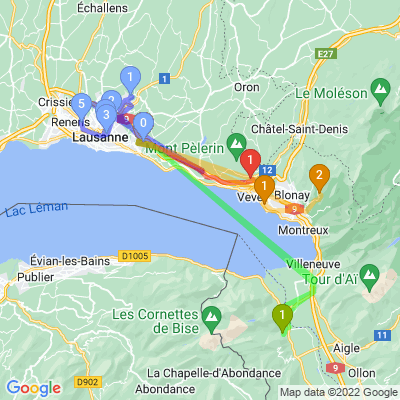

In [159]:
fct_run_maps(shuttle_routes, key)

In [186]:
url = f"https://maps.googleapis.com/maps/api/staticmap" \
      f"?size=400x400&center=59.900503,-135.478011&zoom=4" \
      "&path=weight:3%7Ccolor:orange%7Cenc:_fisIp~u%7CU}%7Ca@pytA_~b@hhCyhS~hResU%7C%7Cx@oig@rwg@amUfbjA}f[roaAynd@%7CvXxiAt{ZwdUfbjAewYrqGchH~vXkqnAria@c_o@inc@k{g@i`]o%7CF}vXaj\h`]ovs@?yi_@rcAgtO%7Cj_AyaJren@nzQrst@zuYh`]v%7CGbldEuzd@%7C%7Cx@spD%7CtrAzwP%7Cd_@yiB~vXmlWhdPez\_{Km_`@~re@ew^rcAeu_@zhyByjPrst@ttGren@aeNhoFemKrvdAuvVidPwbVr~j@or@f_z@ftHr{ZlwBrvdAmtHrmT{rOt{Zz}E%7Cc%7C@o%7CLpn~AgfRpxqBfoVz_iAocAhrVjr@rh~@jzKhjp@``NrfQpcHrb^k%7CDh_z@nwB%7Ckb@a{R%7Cyh@uyZ%7CllByuZpzw@wbd@rh~@%7C%7CFhqs@teTztrAupHhyY}t]huf@e%7CFria@o}GfezAkdW%7C}[ocMt_Neq@ren@e~Ika@pgE%7Ci%7CAfiQ%7C`l@uoJrvdAgq@fppAsjGhg`@%7ChQpg{Ai_V%7C%7Cx@mkHhyYsdP%7CxeA~gF%7C}[mv`@t_NitSfjp@c}Mhg`@sbChyYq}e@rwg@atFff}@ghN~zKybk@fl}A}cPftcAite@tmT__Lha@u~DrfQi}MhkSqyWivIumCria@ciO_tHifm@fl}A{rc@fbjAqvg@rrqAcjCf%7Ci@mqJtb^s%7C@fbjA{wDfs`BmvEfqs@umWt_Nwn^pen@qiBr`xAcvMr{Zidg@dtjDkbM%7Cd_@" \
      "&key={}".format(key)
response = requests.request("GET", url, headers=headers, data=payload)

ValueError: Single '}' encountered in format string

In [185]:
response.text

'<!DOCTYPE html>\n<html lang=en>\n  <meta charset=utf-8>\n  <meta name=viewport content="initial-scale=1, minimum-scale=1, width=device-width">\n  <title>Error 400 (Bad Request)!!1</title>\n  <style>\n    *{margin:0;padding:0}html,code{font:15px/22px arial,sans-serif}html{background:#fff;color:#222;padding:15px}body{margin:7% auto 0;max-width:390px;min-height:180px;padding:30px 0 15px}* > body{background:url(//www.google.com/images/errors/robot.png) 100% 5px no-repeat;padding-right:205px}p{margin:11px 0 22px;overflow:hidden}ins{color:#777;text-decoration:none}a img{border:0}@media screen and (max-width:772px){body{background:none;margin-top:0;max-width:none;padding-right:0}}#logo{background:url(//www.google.com/images/branding/googlelogo/1x/googlelogo_color_150x54dp.png) no-repeat;margin-left:-5px}@media only screen and (min-resolution:192dpi){#logo{background:url(//www.google.com/images/branding/googlelogo/2x/googlelogo_color_150x54dp.png) no-repeat 0% 0%/100% 100%;-moz-border-image:u